In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import numpy             as np

import matplotlib
import sys
import pickle
import itertools

sys.path.append('/home/usc/ie/dcr/hk/ambe_analysis')

# Import Diego's tools
from paquetes.npz_to_df import truehits_info_to_df
from paquetes.npz_to_df import digihits_info_to_df
from paquetes.npz_to_df import simple_track_info_to_df
from paquetes.npz_to_df import track_info_to_df

from tqdm.notebook import tqdm

# pd.set_option('display.max_rows', 100000)
# pd.set_option('display.max_columns', 100000)

%load_ext autoreload
%autoreload 2

In [2]:
def mean_uncertainty(incertidumbres):
    return np.sqrt(np.sum(np.array(incertidumbres)**2)) / len(incertidumbres)

def generate_legend_text(data):
    entries = len(data)
    mean    = np.mean(data)

    data_stat_unc = [np.sqrt(i) for i in data]
    mean_sigma = mean_uncertainty(data_stat_unc)

    # Create legend with statistics
    # For the average rate, we have hits/PMT * A decays/s / decays = hits/(PMT * s)
    legend_text = (f'Entries = {entries}\n'
                    f'Mean = {mean:.2f} $\pm$ {mean_sigma:.2f}'
    )

    return legend_text

def dHist(data, b, label, log, lLocation):
    plt.hist(data, bins=b, histtype="step");
    plt.xlabel(label)
    if log:
        plt.yscale("log")

    legend_text = generate_legend_text(data)

    plt.legend([legend_text], loc=lLocation)

In [3]:
npz     = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_0kHz_NOTRIGGER_50kevents_actualPrototype.npz'
nevents = 50000

# Creación del DataFrame de DigiHits usando la función digihits_info_to_df
df_trueHits = truehits_info_to_df(npz)
df_trueHits = df_trueHits.dropna()
df_simpleTracks = simple_track_info_to_df(npz)
df_simpleTracks = df_simpleTracks.dropna()

In [4]:
df_trueHits[df_trueHits['event_id'].values == 42431]

,event_id,true_hit_parent,true_hit_pmt,true_hit_time,true_hit_start_time,hit_x,hit_y,hit_z,hit_start_x,hit_start_y,hit_start_z,true_hit_creatorProcess,hit_r,hit_start_r


In [5]:
df_simpleTracks[(df_simpleTracks['event_id'].values == 1)].head(10)

,event_id,track_pid,track_id,track_parent,track_creator_process,track_energy,track_ti,track_ri,track_rf
1,1,0,0,0,initial,0.0,0.0,0.0,0.0
1,1,0,0,0,initial,0.0,0.0,0.0,0.0
1,1,22,1,0,initial,1.496841,0.0,10.0,82.20195
1,1,22,2,0,initial,0.46301,67162911906979751437271040.0,10.0,28.289141
1,1,22,3,0,initial,0.106074,67162911906979751437271040.0,10.0,48.523178
1,1,22,4,0,initial,0.763449,67162911906979751437271040.0,10.0,53.962963
1,1,22,5,0,initial,0.583188,67162911906979751437271040.0,10.0,48.803482
1,1,22,6,0,initial,2.614504,67162911906979751437271040.0,10.0,128.925522
1,1,11,7,1,compt,0.748992,1.696278,60.853146,60.881763
1,1,11,10,1,compt,0.535691,3.186351,90.581215,90.581619


# Slide 4: % de eventos nos que si que temos hits

In [6]:
df_trueHits = df_trueHits[(df_trueHits['true_hit_time'].values < 3.6e12)]
df_simpleTracks = df_simpleTracks[(df_simpleTracks["track_ti"].values < 3.6e12)]

In [7]:
events_with_hits = 0
for i in range(nevents):
    if len(df_trueHits[(df_trueHits["event_id"].values == i)]) > 0:
        events_with_hits += 1

print(f"In {events_with_hits} out of {nevents} events hits are produced in the mPMTs. This represent {events_with_hits/nevents*100:.2f}%")

In 9543 out of 50000 events hits are produced in the mPMTs. This represent 19.09%


# Histograma 2D co No. hits e a enerxía da gamma e Profile Plot

In [8]:
initial_gammas_df = df_simpleTracks[(df_simpleTracks["track_pid"].values == 22) & 
                                    (df_simpleTracks["track_creator_process"].values == "initial")]

In [9]:
initial_gammas_df.head()

,event_id,track_pid,track_id,track_parent,track_creator_process,track_energy,track_ti,track_ri,track_rf
1,1,22,1,0,initial,1.496841,0.0,10.0,82.20195
2,2,22,1,0,initial,0.911209,0.0,10.0,83.887283
3,3,22,1,0,initial,0.156377,0.0,10.0,9.778685
3,3,22,2,0,initial,0.231526,0.0,10.0,45.354271
4,4,22,1,0,initial,0.597339,0.0,10.0,51.955643


In [10]:
gamma_energy_per_event = []
no_hits    = []
for i in tqdm(range(nevents), total=nevents):
    gamma_energy_per_event.append(initial_gammas_df[(initial_gammas_df["event_id"].values == i)]['track_energy'].values)
    no_hits.append(len(df_trueHits[(df_trueHits["event_id"].values == i)]))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
all_gamma_energy_per_event = np.concatenate(gamma_energy_per_event)
energy_sum = [np.sum(i) for i in gamma_energy_per_event]

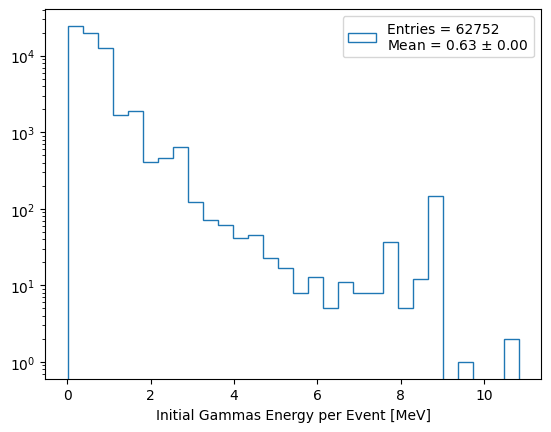

In [12]:
dHist(all_gamma_energy_per_event, 30, "Initial Gammas Energy per Event [MeV]", True, "upper right")

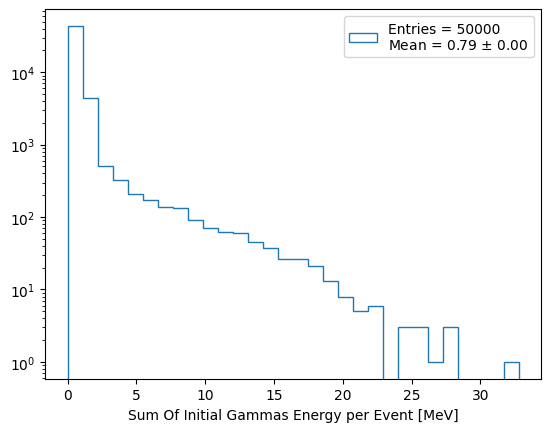

In [13]:
dHist(energy_sum, 30, "Sum Of Initial Gammas Energy per Event [MeV]", True, "upper right")

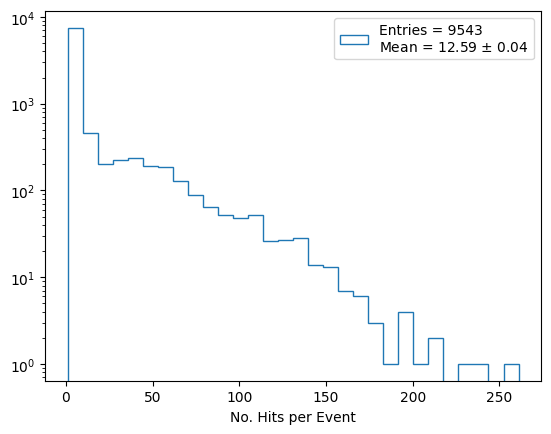

In [14]:
no_hits_nonZero = [i for i in no_hits if i != 0]
dHist(no_hits_nonZero, 30, "No. Hits per Event", True, "upper right")

In [15]:
no_hits_nonZero_mask = (np.array(no_hits) > 0)

In [16]:
energy_sum_for_nonZero_no_hits = np.array(energy_sum)[no_hits_nonZero_mask];

In [17]:
print(len(no_hits_nonZero))
print(len(energy_sum_for_nonZero_no_hits))

9543
9543


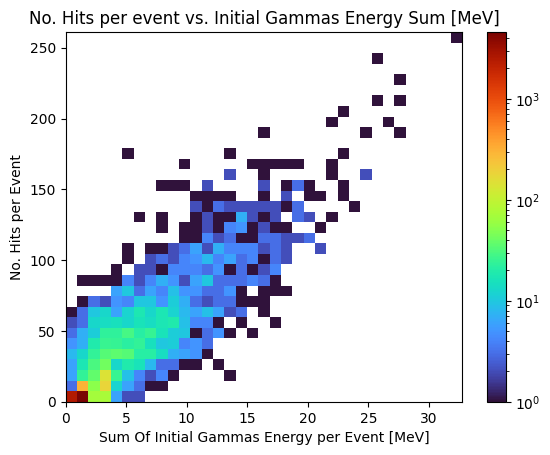

In [18]:
h = plt.hist2d(energy_sum_for_nonZero_no_hits, no_hits_nonZero, bins=(np.linspace(0, np.max(energy_sum_for_nonZero_no_hits), 36), np.linspace(0, np.max(no_hits_nonZero), 36)), norm='log', cmap='turbo');
plt.colorbar(h[3]);
plt.xlabel("Sum Of Initial Gammas Energy per Event [MeV]");
plt.ylabel("No. Hits per Event");
plt.title("No. Hits per event vs. Initial Gammas Energy Sum [MeV]");


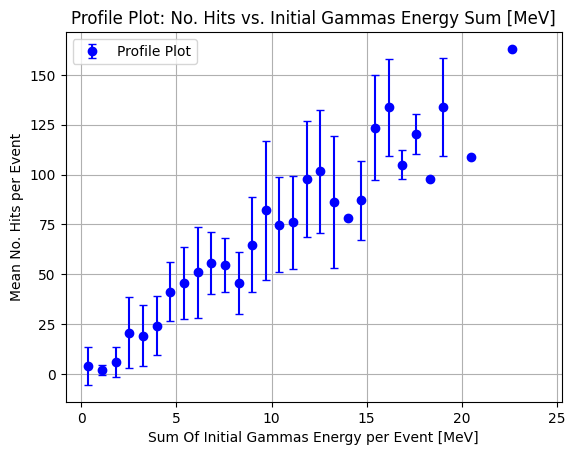

In [19]:
# Definir los bins en el eje de energía (mismo binning que el histograma 2D)
bins_x = np.linspace(min(energy_sum_for_nonZero_no_hits), max(energy_sum_for_nonZero_no_hits), 35)

# Calcular los valores centrales de cada bin en X
bin_centers = 0.5 * (bins_x[:-1] + bins_x[1:])

# Calcular la media y desviación estándar del número de hits en cada bin de energía
y_means = []
y_stds = []

for i in range(len(bins_x)-1):
    mask = (energy_sum_for_nonZero_no_hits >= bins_x[i]) & (energy_sum_for_nonZero_no_hits < bins_x[i+1])
    hits_in_bin = np.array(no_hits_nonZero)[mask]
    
    if len(hits_in_bin) > 0:
        y_means.append(hits_in_bin.mean())
        y_stds.append(hits_in_bin.std())
    else:
        y_means.append(np.nan)  # Para evitar valores vacíos
        y_stds.append(np.nan)

# Graficar el profile plot
plt.figure()
plt.errorbar(bin_centers, y_means, yerr=y_stds, fmt='o', color='blue', capsize=3, label="Profile Plot")
plt.xlabel("Sum Of Initial Gammas Energy per Event [MeV]")
plt.ylabel("Mean No. Hits per Event")
plt.title("Profile Plot: No. Hits vs. Initial Gammas Energy Sum [MeV]")
plt.legend()
plt.grid()
plt.show()

# Prob. de un evento con >0 hits en función da enerxía da gamma

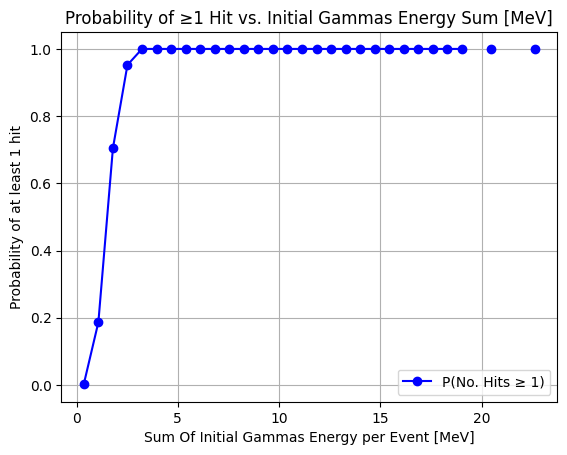

In [20]:
# Definir los bins en el eje de energía (mismo binning que el histograma 2D)
bins_x = np.linspace(min(energy_sum), max(energy_sum), 35)

# Calcular los valores centrales de cada bin en X
bin_centers = 0.5 * (bins_x[:-1] + bins_x[1:])

# Lista para almacenar probabilidades
probs = []

for i in range(len(bins_x)-1):
    mask = (energy_sum >= bins_x[i]) & (energy_sum < bins_x[i+1])
    hits_in_bin = np.array(no_hits)[mask]
    
    if len(hits_in_bin) > 0:
        prob = np.sum(hits_in_bin > 1) / len(hits_in_bin)  # Probabilidad de al menos 1 hit
        probs.append(prob)
    else:
        probs.append(np.nan)  # Evitar bins vacíos

# Graficar la probabilidad
plt.figure()
plt.plot(bin_centers, probs, marker='o', linestyle='-', color='blue', label="P(No. Hits ≥ 1)")
plt.xlabel("Sum Of Initial Gammas Energy per Event [MeV]")
plt.ylabel("Probability of at least 1 hit")
plt.title("Probability of ≥1 Hit vs. Initial Gammas Energy Sum [MeV]")
plt.ylim(-0.05, 1.05)  # Para que la escala vaya de 0 a 1
plt.grid()
plt.legend(loc="lower right")
plt.show()


In [24]:
tracks_9mev = initial_gammas_df[(initial_gammas_df["track_energy"].values > 8.5) &
                                (initial_gammas_df["track_energy"].values < 10)]

In [33]:
np.unique(tracks_9mev["event_id"])

array([   28, 12385, 17125, 33676, 42431, 45672, 49043, 63527, 68685,
       80246, 82049], dtype=int32)

In [92]:
df_simpleTracks[(df_simpleTracks["event_id"].values == 42431)].head(10)

,event_id,track_pid,track_id,track_parent,track_creator_process,track_energy,track_ti,track_ri,track_rf
42431,42431,0,0,0,initial,0.0,0.0,0.0,0.0
42431,42431,0,0,0,initial,0.0,0.0,0.0,0.0
42431,42431,2112,1,0,initial,940.860596,0.0,8.0,10.320152
42431,42431,2112,2,0,initial,940.409241,8.0,8.0,13.648175
42431,42431,2112,3,0,initial,940.831421,0.0,8.0,31.851763
42431,42431,22,4,0,initial,8.999293,16952.0,8.0,82.439728
42431,42431,2112,5,0,initial,940.943359,0.0,8.0,14.349223
42431,42431,22,6,0,initial,0.329018,0.0,8.0,58.740116
42431,42431,22,7,0,initial,1.061363,0.0,8.0,19.670858
42431,42431,22,8,0,initial,1.074504,0.0,8.0,123.787819


In [93]:
electrons_from_energetic_gamma = df_simpleTracks[(df_simpleTracks["event_id"].values == 42431) &
                                                 (df_simpleTracks["track_parent"].values == 4)]["track_id"].values

In [94]:
electrons_from_energetic_gamma

array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 35,
       34, 36], dtype=object)

In [95]:
len(df_trueHits[(df_trueHits["event_id"].values == 42431) &
            (df_trueHits["true_hit_parent"].isin(electrons_from_energetic_gamma))])

69